In [1]:
%cd ..

/fs01/home/abbasgln/codes/medAI/projects/tta


In [2]:
import os
from dotenv import load_dotenv
# Loading environment variables
load_dotenv()

import torch
import torch.nn as nn
import typing as tp
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
import logging
import wandb

import medAI
from medAI.utils.setup import BasicExperiment, BasicExperimentConfig

from utils.metrics import MetricCalculator

from timm.optim.optim_factory import create_optimizer

from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import timm

from copy import copy, deepcopy
import pandas as pd

from datasets.datasets import ExactNCT2013RFImagePatches
from medAI.datasets.nct2013 import (
    KFoldCohortSelectionOptions,
    LeaveOneCenterOutCohortSelectionOptions, 
    PatchOptions
)


In [3]:
LEAVE_OUT='JH'

## Data MEMO

In [8]:
###### No support dataset ######

from baseline_experiment import BaselineConfig
config = BaselineConfig(cohort_selection_config=LeaveOneCenterOutCohortSelectionOptions(leave_out=f"{LEAVE_OUT}"), benign_to_cancer_ratio_train=3.0)

from baseline_experiment import BaselineConfig
from torchvision.transforms import v2 as T
from torchvision.tv_tensors import Image as TVImage

class Transform:
    def __init__(selfT, augment=False):
        selfT.augment = augment
        selfT.size = (256, 256)
        # Augmentation
        selfT.transform = T.Compose([
            T.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0.5),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
        ])  
    
    def __call__(selfT, item):
        patch = item.pop("patch")
        patch = copy(patch)
        patch = (patch - patch.min()) / (patch.max() - patch.min()) \
            if config.instance_norm else patch
        patch = TVImage(patch)
        patch = T.Resize(selfT.size, antialias=True)(patch).float()
        
        label = torch.tensor(item["grade"] != "Benign").long()
        
        if selfT.augment:
            patch_augs = torch.stack([selfT.transform(patch) for _ in range(5)], dim=0)
            return patch_augs, patch, label, item
        
        return -1, patch, label, item


# val_ds_memo = ExactNCT2013RFImagePatches(
#     split="val",
#     transform=Transform(augment=True),
#     cohort_selection_options=config.cohort_selection_config,
#     patch_options=config.patch_config,
#     debug=config.debug,
# )

if config.cohort_selection_config.leave_out == 'UVA':
    config.cohort_selection_config.benign_to_cancer_ratio = 5.0
        
test_ds = ExactNCT2013RFImagePatches(
    split="test",
    transform=Transform(augment=False),
    cohort_selection_options=config.cohort_selection_config,
    patch_options=config.patch_config,
    debug=config.debug,
)


# val_loader_memo = DataLoader(
#     val_ds_memo, batch_size=config.batch_size_test, shuffle=config.shffl_test, num_workers=4
# )
test_loader = DataLoader(
    test_ds, batch_size=config.batch_size, shuffle=False, num_workers=4
)



Computing positions:  17%|█▋        | 349/2060 [00:02<00:09, 173.37it/s]


KeyboardInterrupt: 

## Model

In [5]:
from baseline_experiment import FeatureExtractorConfig

fe_config = FeatureExtractorConfig()

# Create the model
model: nn.Module = timm.create_model(
    fe_config.model_name,
    num_classes=fe_config.num_classes,
    in_chans=1,
    features_only=fe_config.features_only,
    norm_layer=lambda channels: nn.GroupNorm(
                    num_groups=fe_config.num_groups,
                    num_channels=channels
                    ))

CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/baseline_gn_1ratio_loco/baseline_gn_1ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')

model.load_state_dict(torch.load(CHECkPOINT_PATH)['model'])
model.eval()
model.cuda()

a = True

## Run test 

In [6]:
loader = test_loader


metric_calculator = MetricCalculator()
desc = "test"

model.eval()
criterion = nn.CrossEntropyLoss()

for i, batch in enumerate(tqdm(loader, desc=desc)):
    _, images, labels, meta_data = batch
    images = images.cuda()
    labels = labels.cuda()
        
    # Evaluate
    logits = model(images)
    loss = criterion(logits, labels)
                    
    # Update metrics   
    metric_calculator.update(
        batch_meta_data = meta_data,
        probs = nn.functional.softmax(logits, dim=-1).detach().cpu(),
        labels = labels.detach().cpu(),
    )

test:   0%|          | 0/1990 [00:00<?, ?it/s]

In [7]:
# Log metrics every epoch
metrics = metric_calculator.get_metrics()

# Update best score
(best_score_updated,best_score) = metric_calculator.update_best_score(metrics, desc)
best_score_updated = copy(best_score_updated)
best_score = copy(best_score)
        
# Log metrics
metrics_dict = {
    f"{desc}/{key}": value for key, value in metrics.items()
    }

metrics_dict

{'test/patch_auroc': tensor(0.6288),
 'test/patch_accuracy': tensor(0.7483),
 'test/all_inv_patch_auroc': tensor(0.6016),
 'test/all_inv_patch_accuracy': tensor(0.7255),
 'test/core_auroc': tensor(0.7313),
 'test/core_accuracy': tensor(0.8584),
 'test/all_inv_core_auroc': tensor(0.6672),
 'test/all_inv_core_accuracy': tensor(0.8232)}

In [170]:
# core probs and labels
# ids = metric_calculator.remove_low_inv_ids(metric_calculator.core_id_invs)
ids = list(metric_calculator.core_id_probs.keys())
probs = torch.stack(
    [torch.stack(probs_list).argmax(dim=1).mean(dim=0, dtype=torch.float32)
    for id, probs_list in metric_calculator.core_id_probs.items() if id in ids])
probs = torch.cat([(1 - probs).unsqueeze(1), probs.unsqueeze(1)], dim=1)

probs2 = torch.stack(
    [torch.stack(probs_list).mean(dim=0) for id, probs_list in metric_calculator.core_id_probs.items() if id in ids])  

labels = torch.stack(
    [labels_list[0] for id, labels_list in metric_calculator.core_id_labels.items() if id in ids])


In [171]:
import torchmetrics
torchmetrics.functional.auroc(probs, labels, task="multiclass", num_classes=2), torchmetrics.functional.auroc(probs2, labels, task="multiclass", num_classes=2)

(tensor(0.6672), tensor(0.6709))

In [172]:
thr = 0.32
# Step 1: Determine predictions
predictions = (probs[:,1] >= thr)

# Step 2: Calculate TP, TN, FP, FN
TP = ((predictions == 1) & (labels == 1)).sum()
TN = ((predictions == 0) & (labels == 0)).sum()
FP = ((predictions == 1) & (labels == 0)).sum()
FN = ((predictions == 0) & (labels == 1)).sum()

# Step 3: Compute Sensitivity and Specificity
Sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
Specificity = TN / (TN + FP) if TN + FP > 0 else 0

# Step 4: Calculate Balanced Accuracy
(Sensitivity + Specificity) / 2

# ((probs[:,1] >= thr) == labels).sum() / len(labels), ((probs2[:,1] >= thr) == labels).sum() / len(labels)
# torchmetrics.functional.accuracy(probs.argmax(dim=1), labels, task="binary", average="macro", threshold=thr), \
    # torchmetrics.functional.accuracy(probs2, labels, task="multiclass", num_classes=2, average="macro", threshold=thr)

tensor(0.6311)

In [173]:
np.set_printoptions(precision=2)
i = 0
j=0
incorrect_pred_ids = []
correct_pred_ids = []
for id, probs_list in metric_calculator.core_id_probs.items():
    if id in ids:
        if (probs[i][1] >= 0.32) != labels[i]:
            incorrect_pred_ids.append(id)
            print("ID:", id, "Probs", torch.stack(probs_list).max(dim=1)[0].numpy(),"\n" ,"Patch Preds", torch.stack(probs_list).max(dim=1)[1].numpy())
            print("Core prediction", probs[i])
            print("Core label", labels[i])
            j += 1
        else:
            correct_pred_ids.append(id)        
        # print("ID:", id, "Probs", torch.stack(probs_list).max(dim=1)[0].numpy(),"\n" ,"Patch Preds", torch.stack(probs_list).max(dim=1)[1].numpy())
        # print("Core prediction", probs[i])
        # print("Core label", labels[i])
        i += 1
        
# [torch.stack(probs_list).max(dim=1)
#     for id, probs_list in metric_calculator.core_id_probs.items() if id in ids]

ID: 2085 Probs [0.6  0.56 0.69 0.51 0.75 0.77 0.82 0.53 0.51 0.68 0.61 0.7  0.85 0.56
 0.87 0.89 0.96 0.9  0.52 0.78 0.71 0.93 0.53 0.61 0.51 0.69 0.67 0.72
 0.91 0.72 0.87] 
 Patch Preds [0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0]
Core prediction tensor([0.5161, 0.4839])
Core label tensor(0)
ID: 2087 Probs [0.99 0.99 0.98 0.98 0.92 0.9  0.99 0.99 0.99 0.74 0.76 0.89 0.75 0.76
 0.81 0.97 0.84 0.79 0.53 0.64 0.67 0.58 0.74 0.71 0.74 0.84 0.81 0.87
 0.84 0.96 0.9  0.76 0.91 0.94 0.91 0.95 0.61 0.56 0.75 0.78 0.8  0.89
 0.72 0.86 0.59 0.82 0.75 0.83 0.76 0.51 0.57] 
 Patch Preds [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Core prediction tensor([0.7059, 0.2941])
Core label tensor(1)
ID: 2088 Probs [0.92 0.85 0.84 0.81 0.77 0.6  0.83 0.83 0.97 0.51 0.73 0.6  0.76 0.54
 0.85 0.74 0.62 0.63 0.93 0.93 0.61 0.89 0.83 0.82 0.66 0.66 0.75 0.5
 0.68 0.9  0.9  0.91 0.92 0.72 0.62 0.8  0.77 0.67 0.71 0.67 0.64 0.83
 0.

In [174]:
inv_correct_preds = np.array([metric_calculator.core_id_invs[id].item() for id in correct_pred_ids])
inv_incorrect_preds = np.array([metric_calculator.core_id_invs[id].item() for id in incorrect_pred_ids])
len(inv_correct_preds), len(inv_incorrect_preds), len(inv_correct_preds) + len(inv_incorrect_preds), len(ids)

(1111, 478, 1589, 1589)

In [179]:
inv_incorrect_preds = np.array([metric_calculator.core_id_invs[id].item() for id in incorrect_pred_ids])
inv_correct_preds = np.array([metric_calculator.core_id_invs[id].item() for id in correct_pred_ids])
inv_incorrect_preds = inv_incorrect_preds[~np.isnan(inv_incorrect_preds)]
inv_correct_preds = inv_correct_preds[~np.isnan(inv_correct_preds)]
# inv_incorrect_preds = np.nan_to_num(inv_incorrect_preds)
# inv_correct_preds = np.nan_to_num(inv_correct_preds)

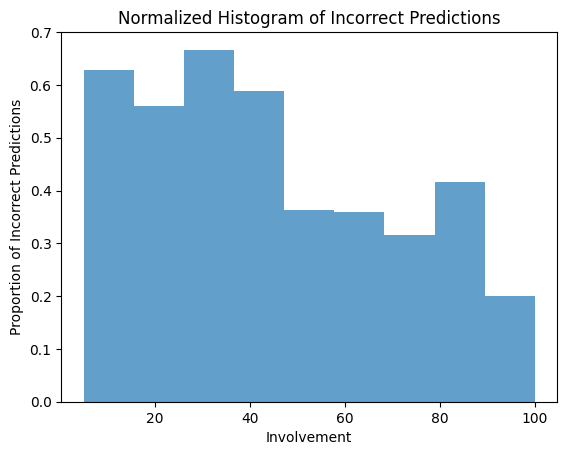

In [180]:
# Calculate the bins to use for both histograms
bins = np.histogram_bin_edges(np.concatenate([inv_incorrect_preds, inv_correct_preds]), bins='auto')

# Calculate histogram for incorrect predictions
hist_incorrect, _ = np.histogram(inv_incorrect_preds, bins=bins)

# Calculate histogram for correct predictions
hist_correct, _ = np.histogram(inv_correct_preds, bins=bins)

# Calculate normalized values: proportion of incorrect predictions in each bin
# To avoid division by zero, use np.where to replace 0 denominators with 1 (these bins will have 0 height anyway)
normalized_values = np.where(hist_incorrect + hist_correct > 0, hist_incorrect / (hist_incorrect + hist_correct), 0)

# Plotting the normalized histogram
plt.bar(bins[:-1], normalized_values, width=np.diff(bins), align='edge', alpha=0.7)
plt.xlabel('Involvement')
plt.ylabel('Proportion of Incorrect Predictions')
plt.title('Normalized Histogram of Incorrect Predictions')
plt.show()